# Assignment 3

**Assignment 3: Evolutionary Algorithms**

**Goal**: Get familiar with evolutionary algorithms by implementing it and applying it to a given non-differentiable optimization task.

In this assignment, we are going to learn about evolutionary algorithms (EAs). The goal is to implement components of an evolutionary algorithm: a recombination operator, a mutation operator, and selection mechanisms, and analyze their behavior. This assignment is open to any choice of the aforementioned components​ as long as they are well motivated.

We are interested in optimizing a given **black-box** function that could be queried (i.e., it returns a value of the objective for given input values), but the gradient wrt the input cannot be calculated. The input to the system is a vector:
$$\mathbf{x} =[\alpha_0, n, \beta, \alpha]^{\top} \in [−2,10] \times [0,10] \times [−5,20] \times [500,2500]. $$

The optimized function is based on the gene repressilator model. For details, please see Section 4.2 in <a href='https://arxiv.org/abs/2002.02869' target='_blank'>HERE</a>.

## 1. Understanding the problem

The considered problem is about finding parameter values of a model widely used in biology, namely, the gene repressilator model. This model represents a simple network in which a gene (mRNA) is produced by a protein, and then this gene is used to produce another protein. Altogether, there are 3 genes and 3 proteins that are connected as follows: $m_1 \rightarrow p_1$, $p_1 \rightarrow m_2$, $m_2 \rightarrow p_2$, $p_2 \rightarrow m_3$, $m_3 \rightarrow p_3$, $p_3 \rightarrow m_1$.

Please run the code below and spend a while on analyzing the signals in the model. Think of the osscilatory character of the signals.

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [1]:
import pickle
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

EPS = 1.e-7

In [2]:
# PLEASE DO NOT REMOVE!
# This is the main class for the gene repressilator model.
# There is no need to understand how it works! You can treat it as a black-box.
# It is important to realize that we can always ask this object to give us 
# an evaluation of given parameter values.
class Repressilator(object):
    def __init__(self, y_real, params):
        super().__init__()
        self.y_real = y_real.copy()
        self.params = params.copy()

  # The definition of the gene repressilator model as a system of ODEs.
    def repressilator_model(self, t, y):
        m1, m2, m3, p1, p2, p3 = y[0], y[1], y[2], y[3], y[4], y[5]

        alpha0 = self.params['alpha0']
        n = self.params['n']
        beta = self.params['beta']
        alpha = self.params['alpha']

        dm1_dt = -m1 + alpha / (1. + max(p3, 0)**n) + alpha0
        dp1_dt = -beta * (p1 - m1)
        dm2_dt = -m2 + alpha / (1. + max(p1, 0)**n) + alpha0
        dp2_dt = -beta * (p2 - m2)
        dm3_dt = -m3 + alpha / (1. + max(p2, 0)**n) + alpha0
        dp3_dt = -beta * (p3 - m3)

        return dm1_dt, dm2_dt, dm3_dt, dp1_dt, dp2_dt, dp3_dt

  # A numerial solver for the model (here we use Runge-Kutta 4.5)
    def solve_repressilator(self):
        # we need to use lambda function if we want to pass some parameters
        solution = solve_ivp(lambda t, y: self.repressilator_model(t, y), 
                             t_span=(self.params['t0'], self.params['t1']),
                             y0=self.params['y0'],
                             method='RK45', t_eval=self.params['t_points'])
        y_points = np.asarray(solution.y)
        return self.params['t_points'], y_points

  # An auxiliary function: setting parameters.
    def set_params(self, x):
        self.params['alpha0'] = x[0]
        self.params['n'] = x[1]
        self.params['beta'] = x[2]
        self.params['alpha'] = x[3]

  # Calculating the objective function.
  # Here, we use the Euclidean distance between the real data and the synthetic data.
    @staticmethod
    def loss(y_real, y_model):
        # we assume only m's are observed!
        y_r = y_real[0:3]
        y_m = y_model[0:3]
        if y_r.shape[1] == y_m.shape[1]:
            return np.mean(np.sqrt(np.sum((y_r - y_m)**2, 0)))
        else:
            return np.infty

    def objective(self, x):
        if len(x.shape) > 1:
            objective_values = []
            for i in range(x.shape[0]):
                xi = x[i]
                self.set_params(xi)

                _, y_model = self.solve_repressilator()
                objective_values.append(self.loss(self.y_real, y_model))

            objective_values = np.asarray(objective_values)
        else:
            self.set_params(x)

            _, y_model = self.solve_repressilator()
            objective_values = self.loss(self.y_real, y_model)

        return objective_values

In [3]:
# PLEASE DO NOT REMOVE!
# Initialize the problem.
# Here we set the real parameters and generate "real" data. To make the problem 
# more realistic, we add a small Gaussian noise.
params = {}
params['alpha0'] = 1.1
params['n'] = 2.9
params['beta'] = 5.5
params['alpha'] = 500
params['t0'] = 0.
params['t1'] = 60.5
params['t_points'] = np.arange(0, 60, 0.5)
params['x0'] = np.asarray([[5.64167522, 2.07180539, 3.56690274, 7.0015145 ]])
params['y0'] = np.asarray([0.0, 0.0, 0.0, 2.0, 1.0, 3.0])

# Generate "real" data
r = Repressilator([0], params)
_, y_real = r.solve_repressilator()
del(r) # we remove the object, just in case
y_real = y_real + np.random.randn(*y_real.shape) * 5. # add noise!

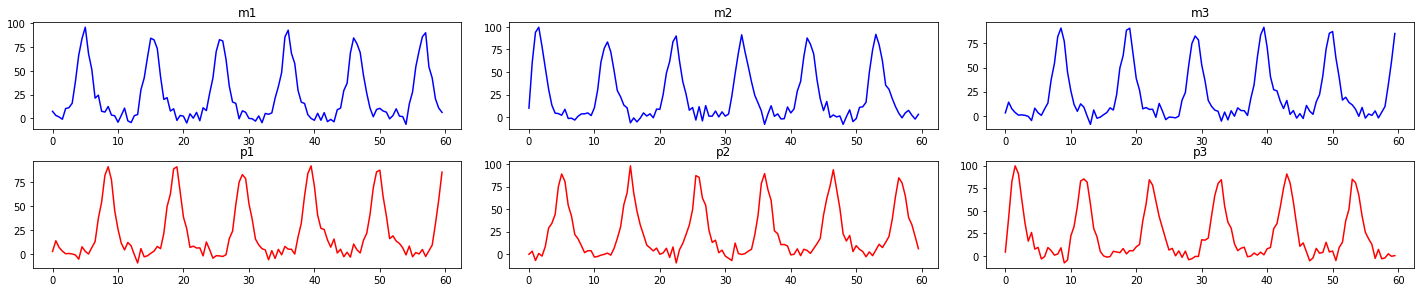

In [4]:
# PLEASE DO NOT REMOVE
# Here, we plot all signals in the model.
# Note that later on, we assume that only gene expression (i.e., m1, m2, m3)
# are observed (blue plots) and proteins (i.e. p1, p2, p3) are unobserved (in red).
t = params['t_points']

fig_data, axs = plt.subplots(2,3,figsize=(20, 4))
fig_data.tight_layout()

for i in range(2):
    for j in range(3):
        if i == 0:
            title = 'm'
            color = 'b'
        else:
            title = 'p'
            color = 'r'
    
        axs[i,j].plot(t, y_real[2*i+j], color)
        axs[i,j].set_title(title + str(j+1))

## 2. Evolutionary Algorithms

In this assignment, you are asked to implement an evolutionary algorithm (EA). Please take a look at the class below and fill in the missing parts. Please keep in mind that you are free to choose any operations as lons as they are appropriate for evolutionary algorithms.

NOTE: Please pay attention to the inputs and outputs of each function.

**Question 1 (0-0.5pt):** Do you use a mutation operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:**
<em>I do use a mutation operator. The mutation operator I have chosen adds samples from a Gaussian distribution with mean around **0** and a diagonal covariance matrix which is proportional to the amplitude of each parameter. The covariance matrix is also multiplied by the standard deviation hyperparameter. This way the mutations to every paramater of each child are not influenced by other paramters as generating a mutation for for $n$ that is the same as a mutation for $\alpha$ would be nonsensical based on how different the scales are. Furthermore, I multiply the children based on how many parents there so that there would always be more children than the population size and each child gets different mutations even if it is a copy of another child.</em>

**Question 2 (0-0.5pt):** Do you use a cross-over operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:**
<em>I do use a cross-over operator. The way I have it implemented is that a fraction of the best parents is selected then at random, features of those parents are selected and again at random inserted in into the worst parents.</em>

**Question 3 (0-0.5pt):** What kind of selection mechanism do you use? Please explain in detail and motivation your choice.

**Answer:**
<em>For survival selection, I use the round-robin tournament method where for each child I check its evaluation againsta fraction of the population and count the number of "wins" where the evaluation is higher. Then the individuals with the best winning scores are selected.</em>

**Question 4 (0-0.5pt):** Do you use any other operation? If yes, please explain and motivate your choice.

**Answer:**
<em>For parent selection I simply use a random uniform selection as the parents are already the best individuals of their generation. Selecting the best ones might lead to dominance and the convergance may stop prematurely at a bad local optimum.</em>

**Question 5 (0-0.5-1pt):** Please provide a pseudo-code for your evolutionary algorithm. Please try to be as formal as possible!

**Answer:**
PLEASE FILL IN

In [5]:
#=========
# GRADING:
# 0 
# 0.5 pt if code works but some functions are incorrect and it is badly explained
# 1.0 pt if code works but some functions are incorrect
# 2.0 pt if code works but it does not correspond to the description above and it is badly explained
# 2.5 pt if code works and it is well explained, but it does not correspond to the description above
# 3.0 pt if code works and it is aligned with the description about, but it is badly explained
# 3.5 pt if code works and it is aligned with the description about, and it is well explained
# 4.0 pt if code works, it is as it was described, it is well explained, and the proposed operations are beyond the lecture!
#=========
# Implement the Evolutionary Algorithm (EA) algorithm. 
# It is equivalent to implementing the step function.
class EA(object):
    def __init__(self, repressilator, pop_size, std, std_low=1, parents=None, bounds_min=None, bounds_max=None):
        self.repressilator = repressilator
        self.pop_size = pop_size
        self.std = std
        self.std_low = std_low
        self.parents = parents if parents is not None else pop_size
        self.bounds_min = np.asarray(bounds_min)
        self.bounds_max = np.asarray(bounds_max)

    def parent_selection(self, x_old, f_old):
        ind = np.random.choice(self.pop_size, self.parents, replace=False)
        return x_old[ind], f_old[ind]

    def recombination(self, x_parents, f_parents):
        best_parents, worst_parents = self.__get_best_and_worst_parents(x_parents, f_parents)
        crossover_features = self.__get_crossover_features(best_parents)
        worst_parents = self.__insert_features(worst_parents, crossover_features)
        x_parents = np.concatenate([best_parents, worst_parents])

        return np.clip(x_parents, self.bounds_min, self.bounds_max)
  
    def __get_best_and_worst_parents(self, x, f):
        x = x[np.argsort(f)]
        threshold = int(np.ceil(self.parents/10))
        return x[:threshold], x[threshold:]
    
    def __get_crossover_features(self, best):
        crossover_features = np.zeros(best.size)
        ind = np.random.choice(best.size, self.parents//10)
        
        for i in ind:
            crossover_features[i] = best.reshape(-1)[i]
        
        return crossover_features.reshape(best.shape)
    
    def __insert_features(self, parents, features):
        for i, parent in enumerate(parents):
            feature = features[np.random.randint(features.shape[0])]
            parent[feature != 0] = 0
            parents[i] = parent + feature
        
        return parents

    def mutation(self, x_children):
        x_children = np.tile(x_children, (int(np.ceil(self.pop_size/self.parents))+1, 1))
        scale = self.bounds_max - self.bounds_min
        scale /= np.max(scale)
        mutation = np.random.multivariate_normal(
            np.zeros(4), np.diag(scale)*self.std,
            size=x_children.shape[0])

        return np.clip(x_children + mutation, self.bounds_min, self.bounds_max)

    def survivor_selection(self, x_old, x_children, f_old, f_children):
        x = np.concatenate([x_old, x_children])
        f = np.concatenate([f_old, f_children])
        scores = self.__winning_scores(f)
        
        ind = np.argsort(scores)
        x_children = x[ind]
        f_children = f[ind]
        ind = np.random.choice(range(self.pop_size, x_children.shape[0]), int(0.2*self.pop_size), replace=False)
        return np.concatenate([x_children[:int(np.ceil(self.pop_size*0.8))], x_children[ind]]), np.concatenate([f_children[:int(np.ceil(self.pop_size*0.8))], f_children[ind]])
    
    def __winning_scores(self, f):
        scores = []
        for f_i in f:
            ind = np.random.choice(x.shape[0], int(np.ceil(self.pop_size/10)), replace=False)
            scores.append(sum([f_i >= i for i in f[ind]]))
        
        return np.asarray(scores)

    # Evaluation step: DO NOT REMOVE!
    def evaluate(self, x):
        return self.repressilator.objective(x)
  
    def step(self, x_old, f_old):
        x_parents, f_parents = self.parent_selection(x_old, f_old)
        x_children = self.recombination(x_parents, f_parents)
        x_children = self.mutation(x_children)
        f_children = self.evaluate(x_children)
        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)
        
        self.std = max(self.std - 1, self.std_low)
                       
        return x, f

**NOTE 1**

Since this assignment allows you implementing your own operations, this is difficult to prepare a code for that. Therefore, please use the code below to find the best set of your hyperparameters in a separate file, and then present your analysis for the best values of the hyperparameters here.

**NOTE 2**

Additionally, please do try various population sizes (25, 50, 100, ...). You will be asked about it later.

In [6]:
# PLEASE DO NOT REMOVE!
num_generations = 250 # if necessary, please increase the number of generations
pop_size = 50
bounds_min = [-2., 0., -5., 500.]
bounds_max = [10., 10., 20., 2500.]
#-------
# PLEASE FILL IN!
# Your hyperparams go here.
std0 = 200
std_low = 1
parents = max(1, pop_size//4) # divisor in range [1, pop_size]
#-------

# Initialize the repressilator
repressilator = Repressilator(y_real, params)

#-------
# PLEASE FILL IN!
# Your object goes here:
ea = EA(repressilator, pop_size, std0, std_low=std_low, parents=parents,
        bounds_min=bounds_min, bounds_max=bounds_max)
#-------

# Init the population
x = np.random.uniform(low=bounds_min, high=bounds_max, size=(pop_size, 4))
f = ea.evaluate(x)

# We want to gather populations and values of the best candidates to further
# analyze the algorithm.
populations = []
populations.append(x)
f_best = [f.min()]

# Run the EA.
for i in range(num_generations):
    if i % int(num_generations * 0.1) == 0:
        print('Generation: {}, best fitness: {:.2f}'.format(i, f.min()))
    x, f = ea.step(x, f)
    populations.append(x)
    if f.min() < f_best[-1]:
        f_best.append(f.min())
    else:
        f_best.append(f_best[-1])
print('FINISHED!')

Generation: 0, best fitness: 46.74
Generation: 25, best fitness: 18.07
Generation: 50, best fitness: 18.07
Generation: 75, best fitness: 12.74
Generation: 100, best fitness: 9.20
Generation: 125, best fitness: 9.20
Generation: 150, best fitness: 8.85
Generation: 175, best fitness: 8.85
Generation: 200, best fitness: 8.85
Generation: 225, best fitness: 8.85
FINISHED!


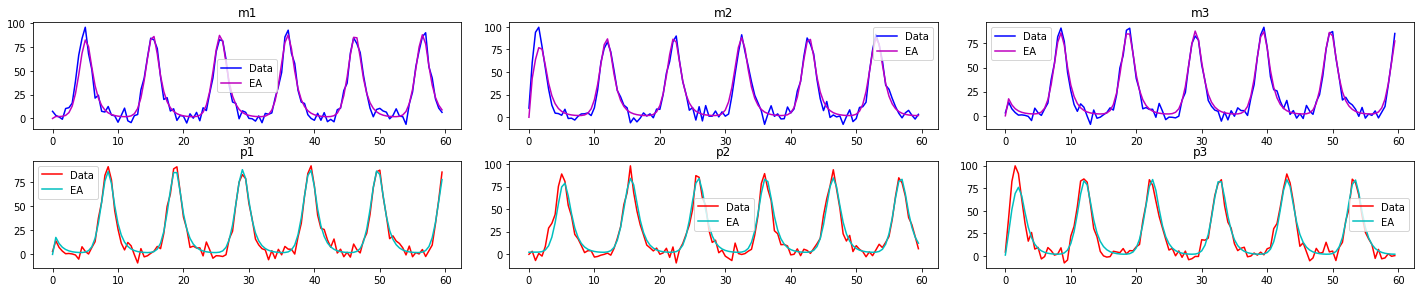

In [7]:
# PLEASE DO NOT REMOVE
# Generate signals for the best performing parameter values
repressilator.set_params(x[f.argmin()],)
t, y_best = repressilator.solve_repressilator()

# Create plots
fig_ea, axs = plt.subplots(2,3,figsize=(20, 4))
fig_ea.tight_layout()

for i in range(2):
    for j in range(3):
        if i == 0:
            title = 'm'
            color = 'b'
            color_m = 'm'
        else:
            title = 'p'
            color = 'r'
            color_m = 'c'

        axs[i,j].plot(t, y_real[2*i+j], color, label='Data')
        axs[i,j].plot(t, y_best[2*i+j], color_m, label='EA')
        axs[i,j].set_title(title + str(j+1))
        axs[i,j].legend()

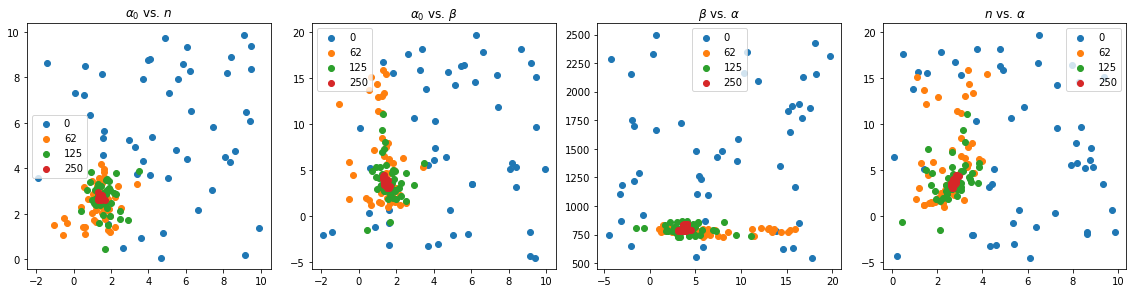

In [8]:
# PLEASE DO NOT REMOVE
# Generate scatterplots for the populations
gens = [0, num_generations//4, num_generations//2, num_generations]
fig_ea_pops, axs = plt.subplots(1,4,figsize=(16, 4))
fig_ea_pops.tight_layout()

for i in range(len(gens)):
    pop_i = populations[gens[i]]
    axs[0].scatter(pop_i[:,0], pop_i[:,1], label=str(gens[i]))
    axs[1].scatter(pop_i[:,0], pop_i[:,2], label=str(gens[i]))
    axs[2].scatter(pop_i[:,2], pop_i[:,3], label=str(gens[i]))
    axs[3].scatter(pop_i[:,1], pop_i[:,2], label=str(gens[i]))
axs[0].legend(), axs[1].legend(), axs[2].legend(), axs[3].legend()
axs[0].set_title(r'$\alpha_0$ vs. $n$')
axs[1].set_title(r'$\alpha_0$ vs. $\beta$')
axs[2].set_title(r'$\beta$ vs. $\alpha$')
axs[3].set_title(r'$n$ vs. $\alpha$')

plt.show()

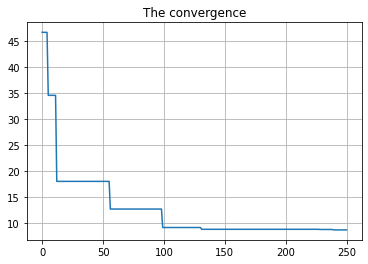

In [9]:
# PLEASE DO NOT REMOVE
# The convergence plot: the best value of the fitness function for each generation
plt.plot(range(len(f_best)), f_best)
plt.title('The convergence')
plt.grid()

## 4. Final remarks: Analysis

Eventually, please answer the following last questions that will allow you to conclude the assignment.

**Question 6 (0-0.5pt)**: After analyzing the results, do you think your algorithm discovered the real values of the parameters? Why? Please indicate which plots indicate that? If not, what is a potential explanation?

**Answer**: PLEASE FILL IN

**Question 7 (0-0.5pt)**: How the population influences the performance of evolutionary algorithms? What population sizes did you use?

**Answer**: <em>I used population sizes of 25, 50, 75, 100, and 150. For each size, I ran the algorithm 5 times with other hyperparameters frozen. The larger values found a good solution fast and then got stuck in local minima while for the lower values, it usually took a bit longer to reach a good solution but after 50 generations, almost always some local minimum was found no matter the population size.</em>

**Question 8 (0-0.5pt)**: What are the advantages of your approach?

**Answer**: <em>It uses a plethora of evolutionary mechanisms which allows for greater tinkering and adjusting to help with the search for the global or at least an adequate local optimum.</em>

**Question 9 (0-0.5pt)**: What are the drawbacks of your approach?

**Answer**: <em>Because of the large number of mechanisms at work it is substantially slower and the search for the right hyperparameter and configurations is very tedious and time-consuming.</em>

**Question 10 (0-0.5pt)**: How could you improve convergence speed of your algorithm? Please provide very specific answer, ideally supported with literature and mathematical formulas.

**Answer**: PLEASE FILL IN

**Question 11 (0-0.5pt)**: How does an EA compares with the Metropolis-Hastings algorithm? What are the similarities? What are the differences?

**Answer**: <em>Both algorithms generate new points which are evaluated and either accpeted or rejected. But that's where the similarities stop. MH is used for sampling, not optimization and vice versa for EA. EAs are also far more modular and there are a greater number of components that can be used such as mutation and cross-over.</em>